
# Framing The Problem

The Genome Assembly Problem can be simplisticly frame as a computational problem called the **shortest common superstring** problem, where we have a set S of input short strings, in this case called k-mers, being k the length of each read. The result is the shortest existing string that contains all substrings from S.

```python
"""
Shortest Common SuperString Problem:

Short sequences (6-mers):

    GTACGT
     TACGTA
      ACGTAC
       CGTACG
        GTACGA
         TACGAT

Expected Shortest Common Superstring:
    
    GTACGTACGAT
"""
```

## Naïve Approach Algorithm:
- Pick a order to sort S substrings
- Glue iteratively adjancent k-mers together by overlapping strings, betwee suffix of `string_i` and prefix of `string_i+1`, and then rest of the string_i+1

```python
"""
# Initial Order

[in]  GTACGT TACGTA ACGTAC CGTACG GTACGA TACGAT
[out] GTACGTACGAT

[in]  TACGTA GTACGT ACGTAC CGTACG GTACGA TACGAT
[out] TACGTACGTACGAT
"""
```
## Upsides:
- Always finds the best answer.

## Downsides: 
- Every order gives a different scs. So we need to compute for every sorting combination `O(n!)`
- Not tractable. **NP-Complete**. It can be solved, but not very fast, and as data length grows it gets slower. 




In [214]:
# Utils
def create_kmers(input_string, k):
    kmers = []
    for i in range(len(input_string) - k):
        kmers.append(input_string[i:(i + k)])
    kmers.append(input_string[-k:])
    return kmers    

create_kmers('a_long_long_long_time', 6)
        

['a_long',
 '_long_',
 'long_l',
 'ong_lo',
 'ng_lon',
 'g_long',
 '_long_',
 'long_l',
 'ong_lo',
 'ng_lon',
 'g_long',
 '_long_',
 'long_t',
 'ong_ti',
 'ng_tim',
 'g_time']

In [2]:
def max_overlap(a, b, min_length=3):
    start = 0
    while True:
        start = a.find(b[:min_length], start)
        if start == -1:
            return 0
        if b.startswith(a[start:]):
            return len(a) - start
        start += 1

In [3]:
import itertools

def scs(ss):
    shortest_sup = None
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]
        for i in range(len(ss)-1):
            overlap_len = max_overlap(ssperm[i], ssperm[i+1], min_length=1)
            sup += ssperm[i+1][overlap_len:]
        if not shortest_sup or len(sup) < len(shortest_sup):
            shortest_sup = sup
    return shortest_sup

# Run scs
input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
output_string = scs(input_strings)
print(f'Shortest Common Superstring is {output_string} of lenght {len(output_string)}')    

Shortest Common Superstring is GTACGTACGAT of lenght 11


## Analysis on the examples:
With the **brute-force** algorithm, it computes on all possible order rearrangements of those 6 reads: 
`n! = 720`
With the **greedy** algorithm, it computes the biggest overlap for each pair of reads, where the order matters, this a -> is different from b -> a. This is `n * (n-1) = 30`

## Greedy Approach Algorithm:

- Create an overlap string directed graph. Nodes represent each k-mer, edges from node_i to node_i+1 represent overlap between suffix
- Find pairs of nodes with the largest overlap between each other. If there are ties between largest pairs, pick one at random. And merge nodes into one, using both strings.
- Itearte through the smaller graph until only one node is left, or there are nodes with no edges. In the latter case just concatenate final nodes.

## Upsides:
- Faster.

## Downsides: 
- Not always finds the shortest string, but a pretty good one. 


```python
"""
0:GTACGT TACGTA ACGTAC CGTACG GTACGA TACGAT
  
1: GTACGTA TACGTAC ACGTACG CGTACGA GTACGAT
   
2: GTACGTAC TACGTACG ACGTACGA CGTACGAT      

...
      
n: GTACGTACGAT 
"""
```


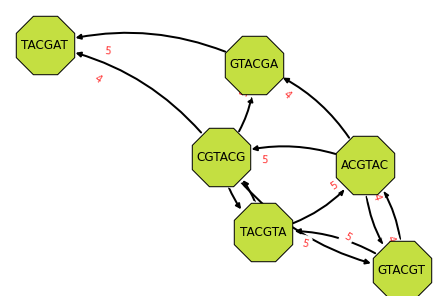

In [234]:
import networkx as nx
import matplotlib.pyplot as plt

def create_overlap_graph(reads, k): 

    # Find all overlaps for all iterations
    overlaps = []
    for a,b in itertools.permutations(reads, 2):
        overlap = max_overlap(a, b, min_length=k)
        if overlap:
            overlaps.append(((a, b), overlap)) 
        
    # Draw Graph
    G = nx.DiGraph()
    for nodes, overlap in overlaps:
        G.add_edge(*nodes, capacity=overlap)
    
    pos = nx.spring_layout(G)
    green = '#C4DF41'
    blue = '#5EA1E1'
    nx.draw(G, pos, with_labels=True,  **{
        'node_color': green,
        'edgecolors': 'black',
        'node_size': 4000,
        'width': 2,
        'connectionstyle':'arc3, rad = 0.2',
        'node_shape': '8' # 'so^>v<dph8'
    })

    _ = nx.draw_networkx_edge_labels(
        G, 
        pos,
        edge_labels=dict(overlaps),
        font_color='red',
        label_pos=0.3,
        alpha=0.8,
    )
    plt.show()


input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
create_overlap_graph(input_strings, 4)

In [233]:
# In this case, when there are ties on the maximum, the first one is picked.
def pick_maximal_overlap(reads, k): 
    read_a, read_b = None, None
    best_overlap_len = 0
    for a,b in itertools.permutations(reads, 2):
        overlap_len = max_overlap(a, b, min_length=k)
        if overlap_len > best_overlap_len:
            read_a, read_b = a, b
            best_overlap_len = overlap_len
    return read_a, read_b, best_overlap_len

In [43]:
input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
len(list(itertools.permutations(input_strings, 2)))

30

In [305]:
def greedy_scs(reads, k, join=True):
    read_a, read_b, overlap_len = pick_maximal_overlap(reads, k)
    while overlap_len > 0:
        # create_overlap_graph(reads, k)
        reads.remove(read_a)
        reads.remove(read_b)
        reads.append(read_a + read_b[overlap_len:])
        read_a, read_b, overlap_len = pick_maximal_overlap(reads, k)
    return ''.join(reads) if join else reads

In [156]:
# Run greedy scs
input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
output_string = greedy_scs(input_strings, 2)
print(f'Shortest Common Superstring is {output_string} of length {len(output_string)}') 

Shortest Common Superstring is GTACGTACGAT of length 11


In [53]:
# Run greedy scs
input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
not_optimal_results = set()
for ssperm in itertools.permutations(input_strings):
    output_string = greedy_scs(list(ssperm), 2)
    if len(output_string) > 11:
        not_optimal_results.add((ssperm, output_string))

In [54]:
# Optimal Results: 450
# Not Optimal Results: 270
len(not_optimal_results)

270

Best Result on 62.5% of the cases


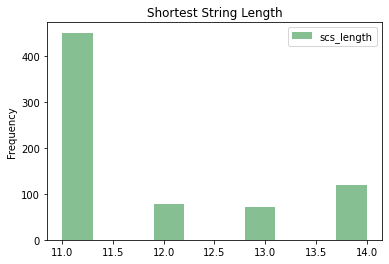

In [111]:
# Run greedy scs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
results = []
for ssperm in itertools.permutations(input_strings):
    output_string = greedy_scs(list(ssperm), 2)
    results.append({
        'input': ssperm,
        'output': output_string,
        'scs_length': len(output_string)
    })

df = pd.DataFrame(results)
min_scs = min(df['scs_length'])
max_scs = max(df['scs_length'])
accuracy = len(df[df['scs_length'] == min_scs])/ len(df)

ax = df.plot(
    kind="hist", 
    title='Shortest String Length',
    color='#86bf91',
)
# _ = ax.set_xticks(np.arange(min_scs, max_scs + 1))
# _ = ax.set_xlim([min_scs, max_scs])
print(f'Best Result on {round(accuracy * 100, 2)}% of the cases')

In [113]:
# Example
df[df['scs_length'] != min_scs].head()

,input,output,scs_length
14,"(GTACGT, TACGTA, GTACGA, CGTACG, ACGTAC, TACGAT)",ACGTACGTACGAT,13
15,"(GTACGT, TACGTA, GTACGA, CGTACG, TACGAT, ACGTAC)",ACGTACGTACGAT,13
17,"(GTACGT, TACGTA, GTACGA, TACGAT, CGTACG, ACGTAC)",ACGTACGTACGAT,13
23,"(GTACGT, TACGTA, TACGAT, GTACGA, CGTACG, ACGTAC)",ACGTACGTACGAT,13
74,"(GTACGT, GTACGA, TACGTA, CGTACG, ACGTAC, TACGAT)",ACGTACGTACGAT,13


In [126]:
# Same Ouput Switching read position 
reads1 = ['GTACGT', 'TACGTA', 'CGTACG', 'ACGTAC', 'GTACGA', 'TACGAT']
reads2 = ['GTACGT', 'TACGTA', 'GTACGA', 'CGTACG', 'ACGTAC', 'TACGAT']

output_string = greedy_scs(reads1, 2)
print(f'Shortest Common Superstring is {output_string} of length {len(output_string)}')

output_string = greedy_scs(reads2, 2)
print(f'Shortest Common Superstring is {output_string} of length {len(output_string)}') 

Shortest Common Superstring is GTACGTACGAT of length 11
Shortest Common Superstring is ACGTACGTACGAT of length 13


## 3rd Law of Assembly - Common Issues
Repeats are extremely bad for assembly algorithms
If the genome has a lot repeats, a lot of kmers would look the same, even though they belong to different locations on the genome.
It causes ambiguity.

**Overcollapsing problem:** It can happen that some repeated sequences from 2 different parts of the genome are tricked to be shown in different locations or in the same one.

# De Bruijn Graph and the Eulerian Walks 
It helps to avoid overcollapsing.
Creates a Multi-graph whit more than 2 direct edges between kmers

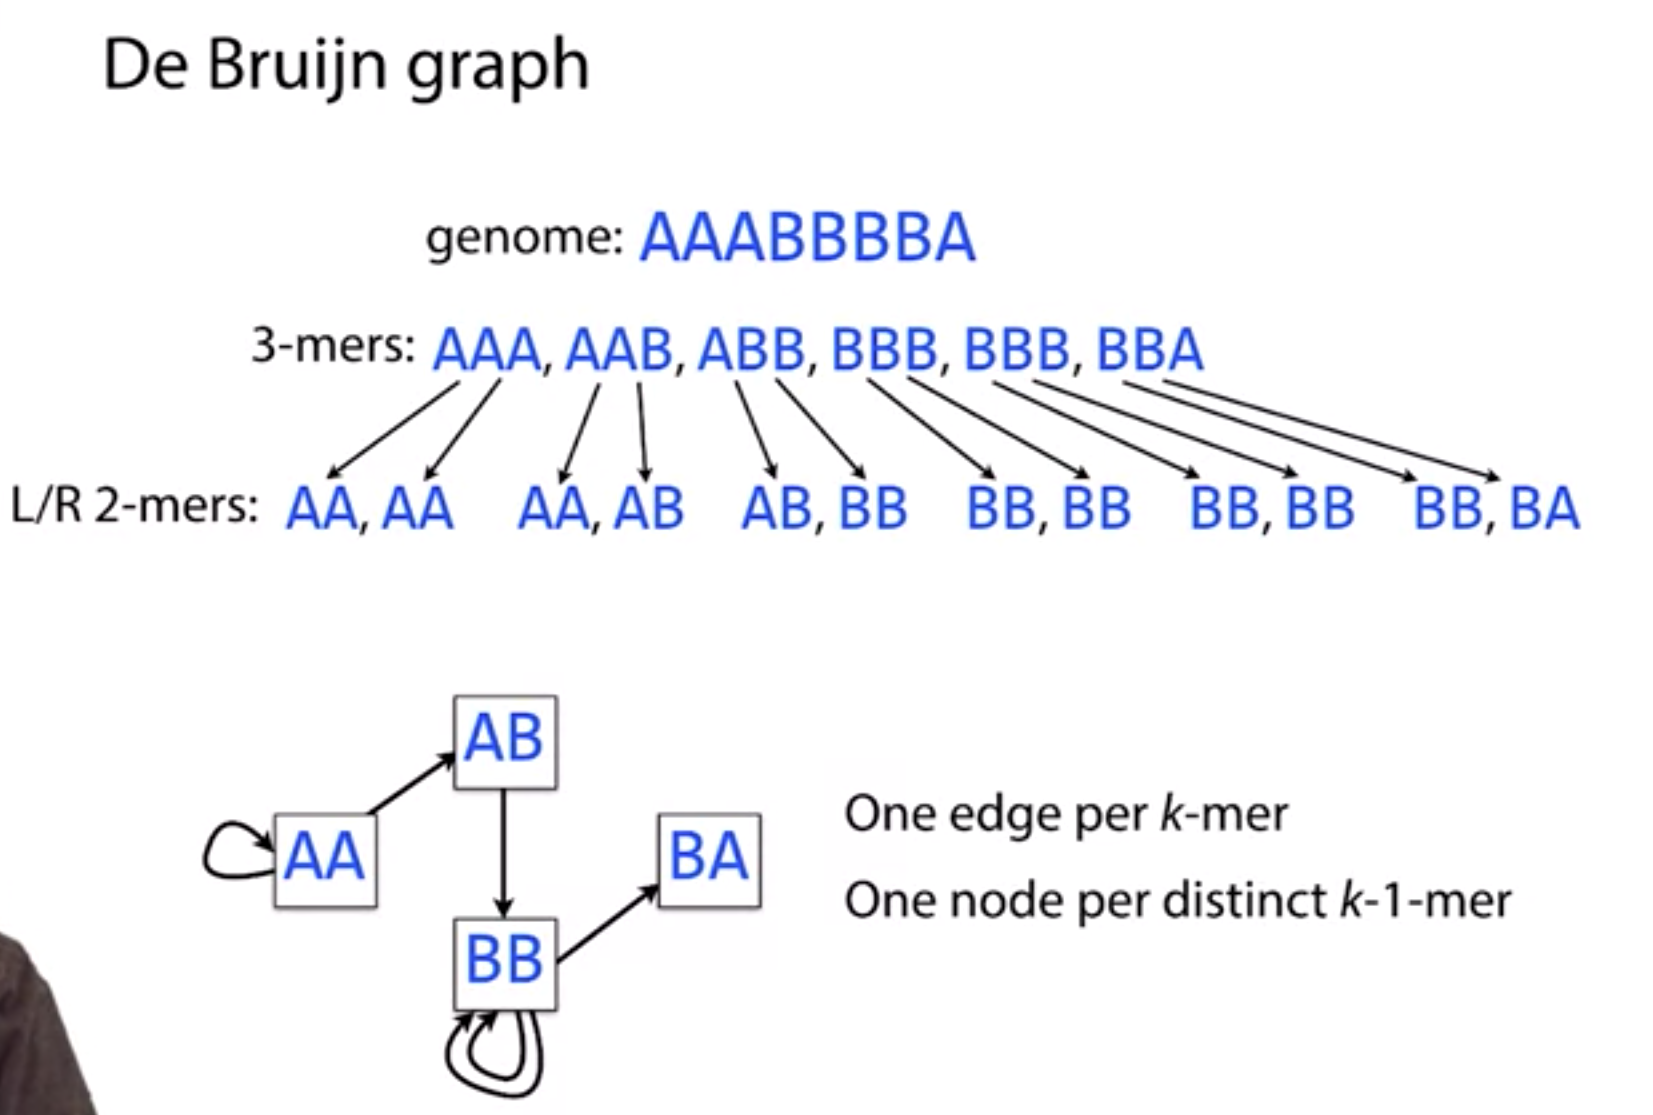

In [39]:
from IPython.display import Image, display
display(Image(filename='deBruijnExample.png'))

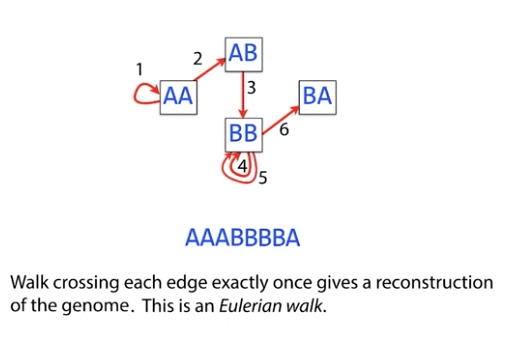

In [40]:
"""
If Instead of Given an aligned Sequence. Can we infer the sequence from a Graph?
Yes. Performing an Eulerian Walk
"""
display(Image(filename='eulerianWalk.png'))

In [58]:
def create_debruijn_graph(input_string, k):
    edges = []
    nodes = set()
    
    for i in range(len(input_string) - k + 1):
        node_a = input_string[i:(i + k - 1)]
        node_b = input_string[(i + 1):(i + k)]
        edges.append((node_a, node_b))
        nodes.add(node_a)
        nodes.add(node_b)
    
    return nodes, edges

nodes, edges = create_debruijn_graph('GTACGTACGAT', 3)
print(f'Nodes={nodes}\nEdges={edges}')

Nodes={'GA', 'TA', 'GT', 'AT', 'CG', 'AC'}
Edges=[('GT', 'TA'), ('TA', 'AC'), ('AC', 'CG'), ('CG', 'GT'), ('GT', 'TA'), ('TA', 'AC'), ('AC', 'CG'), ('CG', 'GA'), ('GA', 'AT')]


digraph "DeBruijn graph" {
 GA [fillcolor=red] ;
 TA [fillcolor=red] ;
 GT [fillcolor=red] ;
 AT [fillcolor=red] ;
 CG [fillcolor=red] ;
 AC [fillcolor=red] ;
 GT -> TA ;
 TA -> AC ;
 AC -> CG ;
 CG -> GT ;
 GT -> TA ;
 TA -> AC ;
 AC -> CG ;
 CG -> GA ;
 GA -> AT ;
}



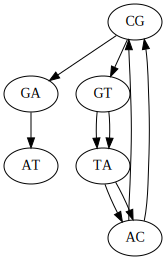

In [293]:
# %load_ext gvmagic
green = '#C4DF41'
def visualize_debruijn_graph(input_string, k):
    nodes, edges = create_debruijn_graph(input_string, k)
    # edges.append(('AT', 'AT'))
    dot_str = 'digraph "DeBruijn graph" {\n'
    for node in nodes:
        dot_str += f' {node} [fillcolor=red] ;\n'
    for node_a, node_b in edges:
        dot_str += f' {node_a} -> {node_b} ;\n'
    dot_str += '}\n'
    return dot_str

print(visualize_debruijn_graph('GTACGTACGAT', 3))
%dotstr visualize_debruijn_graph('GTACGTACGAT', 3)

DeBriujn Graph of k-1 mers for k={i}


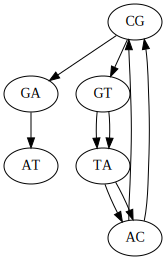

DeBriujn Graph of k-1 mers for k={i}


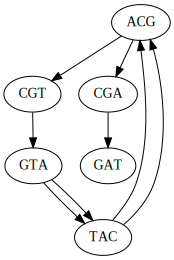

DeBriujn Graph of k-1 mers for k={i}


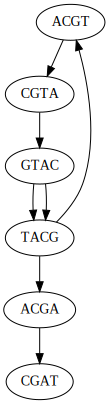

DeBriujn Graph of k-1 mers for k={i}


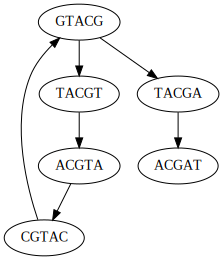

In [294]:
for i in range(3, 7):
    print('DeBriujn Graph of k-1 mers for k={i}')
    %dotstr visualize_debruijn_graph('GTACGTACGAT', i)

('GT', 'TA', 0)
('GT', 'TA', 1)
('TA', 'AC', 0)
('TA', 'AC', 1)
('AC', 'CG', 0)
('AC', 'CG', 1)
('CG', 'GT', 0)
('CG', 'GA', 0)
('GA', 'AT', 0)


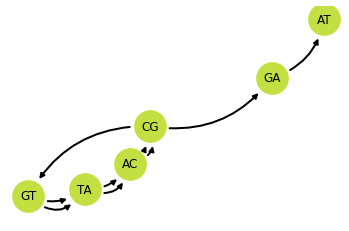

In [296]:
from networkx.drawing.nx_agraph import write_dot

def visualize_debruijn_nxgraph(input_string, k):
    nodes, edges = create_debruijn_graph(input_string, k)
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)

    pos = nx.spring_layout(G)
    green = '#C4DF41'
    blue = '#5EA1E1'
    
    nx.draw_networkx_nodes(G, pos, **{
        'node_color': green,
        'node_size':1000,
        'node_shape': 'o' # 'so^>v<dph8'
    })
    nx.draw_networkx_labels(G, pos)
    
    for edge in G.edges:
        print(edge)
        nx.draw_networkx_edges(G, pos, **{
            'edgelist': [(edge[0],edge[1])],
            'width': 2,
            'arrowsize': 10,
            'min_target_margin': 20,
            'min_source_margin': 20,
            'connectionstyle': f'arc3,rad = {0.3 * (edge[2] + 1)}'
        })

    plt.axis('off')
    plt.show()
    

G = visualize_debruijn_nxgraph('GTACGTACGAT', 3)

In [194]:
# A = nx.nx_agraph.to_agraph(G)
# A.layout('dot')                                                                 
# A.draw('multi.png') 

('AA', 'AA', 0)
('AA', 'AB', 0)
('AB', 'BB', 0)
('BB', 'BB', 0)
('BB', 'BB', 1)
('BB', 'BA', 0)


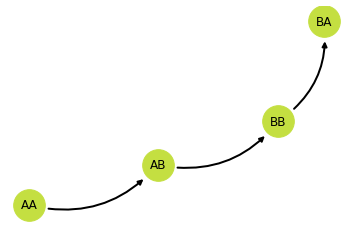

In [297]:
G = visualize_debruijn_nxgraph('AAABBBBA', 3)

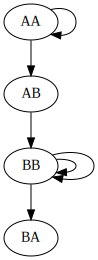

In [298]:
%dotstr visualize_debruijn_graph('AAABBBBA', 3)

# Measure Time Complexity

In [217]:
import math 

input_string = 'a_long_long_time'
k = 6
kmers = create_kmers(input_string, k)
print(f'String {input_string} creates {len(kmers)} {k}-mers')
print(f'SCS runs on O(n!): {math.factorial(len(kmers))} iterations.')

%time scs(kmers)

String a_long_long_time creates 11 6-mers
SCS runs on: 39916800 iterations.
CPU times: user 7min 31s, sys: 3.28 s, total: 7min 34s
Wall time: 8min 21s


'a_long_long_time'

In [242]:
print(f'Greedy SCS runs on O(n^2): {len(kmers) * (len(kmers) - 1)} iterations.')
%time greedy_scs(kmers, 3)

Greedy SCS runs on O(n^2): 0 iterations.
CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 11 µs


'a_long_long_time'

In [289]:
input_string = 'long_long_long_long_time'
k = 6
kmers = create_kmers(input_string, k)
print(f'Greedy SCS runs on O(n^2): {len(kmers) * (len(kmers) - 1)} iterations.')
%time greedy_scs(kmers, 3)

Greedy SCS runs on O(n^2): 342 iterations.
CPU times: user 2.02 ms, sys: 23 µs, total: 2.05 ms
Wall time: 2.06 ms


'long_long_time'

In [292]:
import math 

input_string = 'a_long_long_long_time'
k = 8

kmers = create_kmers(input_string, k)
print(f'String {input_string} creates {len(kmers)} {k}-mers')
print(f'SCS runs on O(n!): {math.factorial(len(kmers))} iterations.')

print('Not even worth to run Brute Force SCS! It will take ~12 days')
# %time scs(kmers)

print(f'Greedy SCS runs on O(n^2): {len(kmers) * (len(kmers) - 1)} iterations.')
%time greedy_scs(kmers, 3)

String a_long_long_long_time creates 14 8-mers
SCS runs on O(n!): 87178291200 iterations.
Not even worth to run Brute Force SCS! It will take ~12 days
Greedy SCS runs on O(n^2): 182 iterations.
CPU times: user 1.05 ms, sys: 275 µs, total: 1.33 ms
Wall time: 1.74 ms


'a_long_long_long_time'

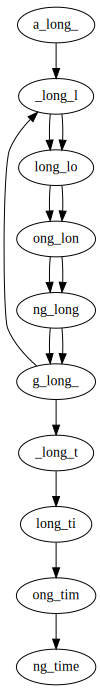

In [304]:
%dotstr visualize_debruijn_graph('a_long_long_long_time', 8)

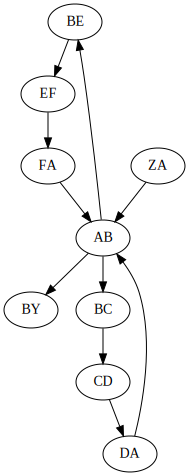

In [302]:
# Issues with DeBruijn Graph
%dotstr visualize_graph('ZABCDABEFABY', 3)

In [315]:
import math 

input_string = 'a_long_long_long_time'
for k in range(4, 10):
    kmers = create_kmers(input_string, k)
    # print(f'{k}: {" ".join(kmers)}')
    # print(f'String {input_string} creates {len(kmers)} {k}-mers')
    # print(f'Greedy SCS runs on O(n^2): {len(kmers) * (len(kmers) - 1)} iterations.')
    reads = greedy_scs(kmers, 3, join=False)
    print(f'{k}: {" ".join(reads)}')

4: ng_time a_long_lo
5: ong_lon a_long_time
6: long_long a_long_time
7: ong_long_lo a_long_time
8: a_long_long_long_time
9: a_long_long_long_time


In [333]:
class DeBruijnGraph:
    """ A de Bruijn multigraph built from a collection of strings.
        User supplies strings and k-mer length k.  Nodes of the de
        Bruijn graph are k-1-mers and edges correspond to the k-mer
        that joins a left k-1-mer to a right k-1-mer. """

    @staticmethod
    def chop(st, k):
        """ Chop a string up into k mers of given length """
        for i in range(0, len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
    
    class Node:
        """ Node in a de Bruijn graph, representing a k-1 mer.  We keep
            track of # of incoming/outgoing edges so it's easy to check
            for balanced, semi-balanced. """
        
        def __init__(self, km1mer):
            self.km1mer = km1mer
            self.nin = 0
            self.nout = 0
        
        def isSemiBalanced(self):
            return abs(self.nin - self.nout) == 1
        
        def isBalanced(self):
            return self.nin == self.nout
        
        def __hash__(self):
            return hash(self.km1mer)
        
        def __str__(self):
            return self.km1mer
    
    def __init__(self, reads, k):
        """ Build de Bruijn multigraph given string iterator and k-mer
            length k """
        self.G = {}     # multimap from nodes to neighbors
        self.nodes = {} # maps k-1-mers to Node objects
        for st in reads:
            for kmer, km1L, km1R in self.chop(st, k):
                nodeL, nodeR = None, None
                if km1L in self.nodes:
                    nodeL = self.nodes[km1L]
                else:
                    nodeL = self.nodes[km1L] = self.Node(km1L)
                if km1R in self.nodes:
                    nodeR = self.nodes[km1R]
                else:
                    nodeR = self.nodes[km1R] = self.Node(km1R)
                nodeL.nout += 1
                nodeR.nin += 1
                self.G.setdefault(nodeL, []).append(nodeR)
        
        # Iterate through nodes and tally how many are balanced,
        # semi-balanced, or neither
        self.nsemi, self.nbal, self.nneither = 0, 0, 0
        
        # Keep track of head and tail nodes in the case of a graph with
        # Eularian path (not cycle)
        self.head, self.tail = None, None
        for node in self.nodes.values():
            if node.isBalanced():
                self.nbal += 1
            elif node.isSemiBalanced():
                if node.nin == node.nout + 1:
                    self.tail = node
                if node.nin == node.nout - 1:
                    self.head = node
                self.nsemi += 1
            else:
                self.nneither += 1
    
    def nnodes(self):
        """ Return # nodes """
        return len(self.nodes)
    
    def nedges(self):
        """ Return # edges """
        return len(self.G)
    
    def hasEulerianPath(self):
        """ Return true iff graph has Eulerian path. """
        return self.nneither == 0 and self.nsemi == 2
    
    def hasEulerianCycle(self):
        """ Return true iff graph has Eulerian cycle. """
        return self.nneither == 0 and self.nsemi == 0
    
    def isEulerian(self):
        """ Return true iff graph has Eulerian path or cycle """
        return self.hasEulerianPath() or self.hasEulerianCycle()
    
    def eulerianPath(self):
        """ Find and return Eulerian path or cycle (as appropriate) """
        assert self.isEulerian()
        g = self.G
        if self.hasEulerianPath():
            g = g.copy()
            assert self.head is not None
            assert self.tail is not None
            g.setdefault(self.tail, []).append(self.head)
        # graph g has an Eulerian cycle
        tour = []
        src = g.iterkeys().next() # pick arbitrary starting node
        
        def __visit(n):
            while len(g[n]) > 0:
                dst = g[n].pop()
                __visit(dst)
            tour.append(n)
        
        __visit(src)
        tour = tour[::-1][:-1]
            
        if self.hasEulerianPath():
            # Adjust node list so that it starts at head and ends at tail
            sti = tour.index(self.head)
            tour = tour[sti:] + tour[:sti]
        
        # Return node list
        return map(str, tour)
        
    def toDot(self, dotFh, weights=False):
        """ Write dot representation to given filehandle.  If 'weights'
            is true, label edges corresponding to distinct k-1-mers
            with weights, instead of writing a separate edge for each
            copy of a k-1-mer. """
        dotFh.write("digraph \"Graph\" {\n")
        dotFh.write("  bgcolor=\"transparent\";\n")
        for node in self.G.keys():
            lab = node.km1mer
            dotFh.write("  %s [label=\"%s\"] ;\n" % (lab, lab))
        for src, dsts in self.G.items():
            srclab = src.km1mer
            if weights:
                weightmap = {}
                if weights:
                    for dst in dsts:
                        weightmap[dst] = weightmap.get(dst, 0) + 1
                for dst, v in weightmap.iteritems():
                    dstlab = dst.km1mer
                    dotFh.write("  %s -> %s [label=\"%d\"] ;\n" % (srclab, dstlab, v))
            else:
                for dst in dsts:
                    srclab = src.km1mer
                    dstlab = dst.km1mer
                    dotFh.write("  %s -> %s [label=\"\"] ;\n" % (srclab, dstlab))
        dotFh.write("}\n")

input_string = 'a_long_long_long_time'
k = 6
reads = create_kmers(input_string, k)
G = DeBruijnGraph(reads, 6)

In [322]:
def kmers(st, k):
    """ Chop a string up into k mers of given length """
    for i in range(0, len(st)-(k-1)):
        yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
        
list(kmers('a_long_long_long_time', 6))

[('a_long', 'a_lon', '_long'),
 ('_long_', '_long', 'long_'),
 ('long_l', 'long_', 'ong_l'),
 ('ong_lo', 'ong_l', 'ng_lo'),
 ('ng_lon', 'ng_lo', 'g_lon'),
 ('g_long', 'g_lon', '_long'),
 ('_long_', '_long', 'long_'),
 ('long_l', 'long_', 'ong_l'),
 ('ong_lo', 'ong_l', 'ng_lo'),
 ('ng_lon', 'ng_lo', 'g_lon'),
 ('g_long', 'g_lon', '_long'),
 ('_long_', '_long', 'long_'),
 ('long_t', 'long_', 'ong_t'),
 ('ong_ti', 'ong_t', 'ng_ti'),
 ('ng_tim', 'ng_ti', 'g_tim'),
 ('g_time', 'g_tim', '_time')]

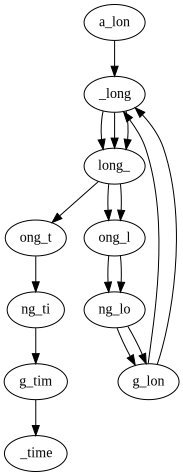

In [351]:
# Plot Graph
dot_filename = 'deBruijn.dot'
with open(dot_filename, 'wt') as dotfile:
    G.toDot(dotfile)

with open(dot_filename, 'rt') as dotfile:
    %dotstr dotfile.read()